<a href="https://colab.research.google.com/github/toluale/IS-733-Project/blob/main/Prediction_of_the_output_power_of_a_wind_turbine_(IS_733_project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading packages for preprocessing and data visualization 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from math import sqrt 

Loading the 2 datasets 

In [ ]:
path1 = 'turbine_dataSet_with(33features).csv'
df1 = pd.read_csv(path1)

path2 = 'la-haute-borne-data-2017-2020.csv'
df2 = pd.read_csv(path2, sep=';')

In [ ]:
df2.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80721,2017-02-08T08:00:00+01:00,44.990002,44.990002,44.990002,0.0,14.0,14.0,14.0,0.0,...,NaN,NaN,358.04999,NaN,NaN,NaN,358.04999,NaN,NaN,NaN
1,R80721,2017-01-26T02:40:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R80721,2017-01-26T13:50:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R80721,2017-01-26T15:00:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R80721,2017-02-18T01:10:00+01:00,44.990002,44.990002,44.990002,0.0,17.0,17.0,17.0,0.0,...,NaN,NaN,7.99000,NaN,NaN,NaN,7.99000,NaN,NaN,NaN


In [ ]:
df2.drop([col for col in df2.columns if 'min' in col],axis=1,inplace=True)
df2.drop([col for col in df2.columns if 'max' in col],axis=1,inplace=True)
df2.drop([col for col in df2.columns if 'std' in col],axis=1,inplace=True)
df2.drop([col for col in df2.columns if 'Va1_avg' in col],axis=1,inplace=True)
df2.drop([col for col in df2.columns if 'Va2_avg' in col],axis=1,inplace=True)
df2.drop([col for col in df2.columns if 'Pas_avg' in col],axis=1,inplace=True)
df2.drop([col for col in df2.columns if 'Va1' in col],axis=1,inplace=True)
df2.drop([col for col in df2.columns if 'Va2' in col],axis=1,inplace=True)
df2.drop([col for col in df2.columns if 'Pas' in col],axis=1,inplace=True)

In [ ]:
df2.columns = df2.columns.str.rstrip("_avg")
df2.head()

,Wind_turbine_name,Date_time,B,Rt,DCs,Cm,P,Q,S,Cosphi,...,W,V,Ot,Nf,Nu,Rs,Rbt,Rm,Wa_c,Na_c
0,R80721,2017-02-08T08:00:00+01:00,44.990002,14.0,38.369999,2.39,-1.89000,0.000000,1.89000,1.00,...,358.049990,39.939999,4.80,50.000000,698.40002,0.33,19.020000,-18.889999,358.04999,358.04999
1,R80721,2017-01-26T02:40:00+01:00,-1.000000,10.0,1204.140000,1796.71,197.32001,22.200001,198.58000,0.99,...,74.470001,11.000000,-7.16,50.009998,704.65997,11.48,21.610001,1562.970000,NaN,NaN
2,R80721,2017-01-26T13:50:00+01:00,-1.000000,10.0,1179.860000,1662.15,176.45000,18.620001,177.53000,0.99,...,73.949997,3.890000,1.79,50.000000,704.53003,11.25,23.000000,1418.660000,NaN,NaN
3,R80721,2017-01-26T15:00:00+01:00,-1.000000,10.0,1198.470000,1732.66,190.61000,21.770000,191.96001,0.99,...,69.110001,-0.990000,0.85,50.009998,705.90002,11.43,22.700001,1497.980000,NaN,NaN
4,R80721,2017-02-18T01:10:00+01:00,44.990002,17.0,159.840000,2.42,-2.88000,0.000000,2.89000,1.00,...,7.990000,8.180000,6.73,49.970001,701.59003,1.52,23.209999,-172.480000,7.99000,7.99000


In [ ]:
df2.columns

Index(['Wind_turbine_name', 'Date_time', 'B', 'Rt', 'DCs', 'Cm', 'P', 'Q', 'S',
       'Cosphi', 'Ds', 'Db1t', 'Db2t', 'Dst', 'Gb1t', 'Gb2t', 'Git', 'Gost',
       'Y', 'Yt', 'Ws1', 'Ws2', 'Ws', 'W', 'V', 'Ot', 'Nf', 'Nu', 'Rs', 'Rbt',
       'Rm', 'Wa_c', 'Na_c'],
      dtype='object')

Combining the datasets

In [ ]:
df = pd.concat([df1, df2])

In [ ]:
df.describe(include='all')

,Wind_turbine_name,Date_time,B,Rt,DCs,Cm,P,Q,S,Cosphi,...,W,V,Ot,Nf,Nu,Rs,Rbt,Rm,Wa_c,Na_c
count,1057968,1057968,1.051338e+06,1.051341e+06,1.051341e+06,1.051341e+06,1.051632e+06,1.048182e+06,1.051339e+06,1.051341e+06,...,1.051632e+06,912834.000000,1.051341e+06,1.051339e+06,1.051339e+06,1.048714e+06,1.051341e+06,1.048000e+06,840171.000000,840171.000000
unique,4,264354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,R80721,2017-03-26T03:30:00+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,264528,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.349957e+01,1.936010e+01,1.061362e+03,2.092587e+03,3.371042e+02,2.707472e+01,3.406552e+02,9.901419e-01,...,1.800533e+02,0.494288,1.210643e+01,4.998357e+01,6.997137e+02,1.019044e+01,2.724552e+01,1.994197e+03,177.332344,178.196225
std,NaN,NaN,2.775644e+01,6.282772e+00,6.213384e+02,2.301626e+03,4.316323e+02,3.016224e+01,4.310908e+02,4.317508e-02,...,9.438705e+01,24.774746,7.849903e+00,6.329083e-01,9.952810e+00,5.826885e+00,6.290981e+00,2.279015e+03,95.363257,95.643383
min,NaN,NaN,-1.212600e+02,0.000000e+00,-5.749000e+02,-4.453070e+03,-1.849000e+01,-1.969500e+02,0.000000e+00,-9.900000e-01,...,0.000000e+00,-179.950000,-2.732000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-2.732000e+02,-9.554600e+02,0.000000,0.000000
25%,NaN,NaN,-9.900000e-01,1.403000e+01,9.641200e+02,3.662600e+02,1.173000e+01,2.310000e+00,2.237000e+01,9.900000e-01,...,9.688000e+01,-5.870000,6.130000e+00,4.998000e+01,6.967400e+02,9.229999e+00,2.418000e+01,1.169400e+02,85.599998,86.220001
50%,NaN,NaN,-9.700000e-01,1.900000e+01,1.182270e+03,1.595400e+03,1.712900e+02,2.201000e+01,1.739400e+02,1.000000e+00,...,1.974500e+02,-0.170000,1.171000e+01,4.999000e+01,6.996400e+02,1.128000e+01,2.795000e+01,1.367135e+03,195.070010,196.539990
75%,NaN,NaN,5.120000e+00,2.400000e+01,1.568590e+03,2.959260e+03,4.801100e+02,3.622000e+01,4.818150e+02,1.000000e+00,...,2.481400e+02,6.030000,1.747000e+01,5.000000e+01,7.026900e+02,1.498000e+01,3.130000e+01,2.887823e+03,247.179990,248.539990


In [ ]:
df.to_csv('combined_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057968 entries, 0 to 217587
Data columns (total 33 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Wind_turbine_name  1057968 non-null  object 
 1   Date_time          1057968 non-null  object 
 2   B                  1051338 non-null  float64
 3   Rt                 1051341 non-null  float64
 4   DCs                1051341 non-null  float64
 5   Cm                 1051341 non-null  float64
 6   P                  1051632 non-null  float64
 7   Q                  1048182 non-null  float64
 8   S                  1051339 non-null  float64
 9   Cosphi             1051341 non-null  float64
 10  Ds                 1050263 non-null  float64
 11  Db1t               1051341 non-null  float64
 12  Db2t               1051341 non-null  float64
 13  Dst                1051341 non-null  float64
 14  Gb1t               1051341 non-null  float64
 15  Gb2t               1051341 non-nu

In [ ]:
df.shape

(1057968, 33)

In [ ]:
df

,Wind_turbine_name,Date_time,B,Rt,DCs,Cm,P,Q,S,Cosphi,...,W,V,Ot,Nf,Nu,Rs,Rbt,Rm,Wa_c,Na_c
0,R80711,2013-01-07T01:20:00+01:00,41.160000,12.65,204.71001,-6.15,-1.380000,0.000000,1.38,1.00,...,22.77000,4.04,5.25,49.980000,705.81000,1.91,18.299999,-69.540001,37.77000,33.75000
1,R80711,2013-01-05T22:20:00+01:00,-1.000000,12.95,1157.03000,1556.76,161.860000,20.170000,163.41,0.99,...,298.35001,12.88,4.77,50.020000,703.96002,11.00,20.709999,1302.110000,313.35001,279.92999
2,R80711,2013-01-06T08:30:00+01:00,-1.000000,13.74,1021.18000,1142.24,91.400002,22.740000,94.32,0.96,...,226.59000,-5.09,5.84,49.980000,701.56000,9.70,22.000000,851.960020,241.59000,246.67999
3,R80711,2013-01-05T21:10:00+01:00,44.990002,12.14,122.29000,-6.09,-0.920000,0.000000,0.92,1.00,...,265.75000,6.64,5.36,49.959999,698.96997,1.14,19.400000,-76.339996,280.75000,274.12000
4,R80711,2013-01-06T11:20:00+01:00,-0.760000,13.78,1041.27000,1052.10,87.900002,75.080002,124.47,0.77,...,278.01001,-0.86,6.57,49.980000,700.78003,9.90,23.700001,785.609990,293.01001,293.87000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217583,R80721,2017-12-13T23:10:00+01:00,1.690000,15.11,1792.47000,8684.33,1632.280000,141.780000,1639.28,0.99,...,243.77000,NaN,7.25,49.960000,716.27000,17.14,29.050000,8669.700000,NaN,NaN
217584,R80721,2017-12-14T03:30:00+01:00,6.350000,16.15,1796.49000,10328.00,1940.510000,177.570000,1948.76,1.00,...,248.92000,NaN,5.33,50.000000,709.20000,17.18,28.430000,10289.200000,NaN,NaN
217585,R80721,2017-12-14T04:20:00+01:00,-0.570000,17.00,1792.77000,7553.16,1417.710000,143.310000,1425.48,0.99,...,238.99000,NaN,4.87,50.000000,701.74000,17.15,28.700000,7531.800000,NaN,NaN
217586,R80721,2017-12-14T05:10:00+01:00,-0.830000,17.00,1792.55000,6745.68,1266.860000,97.180000,1271.21,1.00,...,228.62000,NaN,4.40,50.040000,696.59000,17.14,28.700000,6726.640000,NaN,NaN


# Explaination of each features:
Wind_turbine_name = ( 4turbine- R80711, R80736, R80790, R80721)

Date_time: data from 2013-2016, Data has been recorded within 10 mints intervals.

B = average pitch angle (in degree)

Rt = average hub temperature in degree celcius (0C)

DCs = average generator converter speed (rpm)

Cm = average converter torque (Nm)

P = average active_power (KW)

Q = average Reactive power (KVAr)

S = average apparent_power (kVA)

Cosphi = average power factor

Ds= average generator speed (rpm)

Db1t = average generator bearing1 temperature (deg_C)

Db2t = average generator bearing2 temperature (deg_C)

Dst = average generator stator temperature (deg_C)

Gb1t= average gearbox bearing 1 temperature (deg_C)

Gb2t = average gearbox bearing 2 temperature (deg_C)

Git =average gearbox inlet temperature (deg_C)

Gost =average gearbox_oil_sump_temperature (deg_C)

Y = average Nacelle_angle (degree)

Yt = average Nacelle_temperature (deg_C)

Ws1 = average Wind_speed_1 (m/s) from First anemometer on the nacelle

Ws2 = average wind speed2 (m/s) from second anemometer on the nacelle

Ws= average wind speed (m/s)

W = average Absolute_wind_direction (deg)

V = average Vane_position (degree)

Ot = average Outdoor_temperature (deg_C)

Nf = average Grid_frequency (Hz)

Nu = average Grid_voltage (V)

Rs = average rotor speed (rpm)

Rbt = average rotor bearing temperature (deg_C)

Rm = average torque (Nm)

Wa_c= average Absolute_wind_direction_corrected(degree)

 Na_c = average Nacelle_angle_corrected (degree)

In [ ]:
#Null or missing values in the data

df.isna().sum()

Wind_turbine_name         0
Date_time                 0
B                      6630
Rt                     6627
DCs                    6627
Cm                     6627
P                      6336
Q                      9786
S                      6629
Cosphi                 6627
Ds                     7705
Db1t                   6627
Db2t                   6627
Dst                    6627
Gb1t                   6627
Gb2t                   6627
Git                    6627
Gost                   6627
Y                      6336
Yt                     6627
Ws1                    7615
Ws2                    7579
Ws                     6336
W                      6336
V                    145134
Ot                     6627
Nf                     6629
Nu                     6629
Rs                     9254
Rbt                    6627
Rm                     9968
Wa_c                 217797
Na_c                 217797
dtype: int64

Droping features with a lot of missing value

In [ ]:
df.drop([col for col in df.columns if 'Wa_c' in col],axis=1,inplace=True)
df.drop([col for col in df.columns if 'Na_c' in col],axis=1,inplace=True)
df.drop([col for col in df.columns if 'V' in col],axis=1,inplace=True)

In [ ]:
#Counting by the number of turbines

df['Wind_turbine_name'].value_counts()

R80721    264528
R80711    264528
R80736    264528
R80790    264384
Name: Wind_turbine_name, dtype: int64

In [ ]:
#Drop null values

df.dropna(inplace=True)

In [ ]:
df.isna().sum()

Wind_turbine_name    0
Date_time            0
B                    0
Rt                   0
DCs                  0
Cm                   0
P                    0
Q                    0
S                    0
Cosphi               0
Ds                   0
Db1t                 0
Db2t                 0
Dst                  0
Gb1t                 0
Gb2t                 0
Git                  0
Gost                 0
Y                    0
Yt                   0
Ws1                  0
Ws2                  0
Ws                   0
W                    0
Ot                   0
Nf                   0
Nu                   0
Rs                   0
Rbt                  0
Rm                   0
dtype: int64

In [ ]:
df.shape

(1046337, 30)

In [ ]:
df['Wind_turbine_name'].value_counts() # after droping rows with null values

R80711    261951
R80721    261608
R80790    261504
R80736    261274
Name: Wind_turbine_name, dtype: int64

In [ ]:
#Create a dataframe with each turbine model

df1 = df.loc[(df['Wind_turbine_name']== 'R80711')]
df2 = df.loc[(df['Wind_turbine_name']== 'R80736')]
df3 = df.loc[(df['Wind_turbine_name']== 'R80790')]
df4 = df.loc[(df['Wind_turbine_name']== 'R80721')]

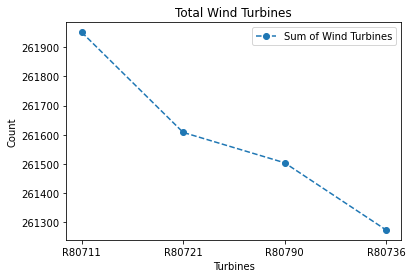

In [ ]:
#Line Plot showing the count for each turbine model

#df['Wind_turbine_name'].value_counts().plot(kind='barh')
plt.plot(df['Wind_turbine_name'].value_counts(), linestyle='--', marker='o', label = 'Sum of Wind Turbines')
plt.legend()
plt.xlabel('Turbines')
plt.ylabel('Count')
plt.title('Total Wind Turbines')
plt.show()

# Visualizing outliers using the power curve for each turbine model

Scatterplot for average power and average wind speed for each wind turbine showing the power curve for each turbine (I am selecting 'apparent power' as my output power since it is the sum of power generated by the turbine.
Theoretically wind speed is the most important single feature at predicting the output power of a wind turbine.
https://www.academia.edu/25598407/Using_Data-Mining_Approaches_for_Wind_Turbine_Power_Curve_Monitoring_A_Comparative_Study

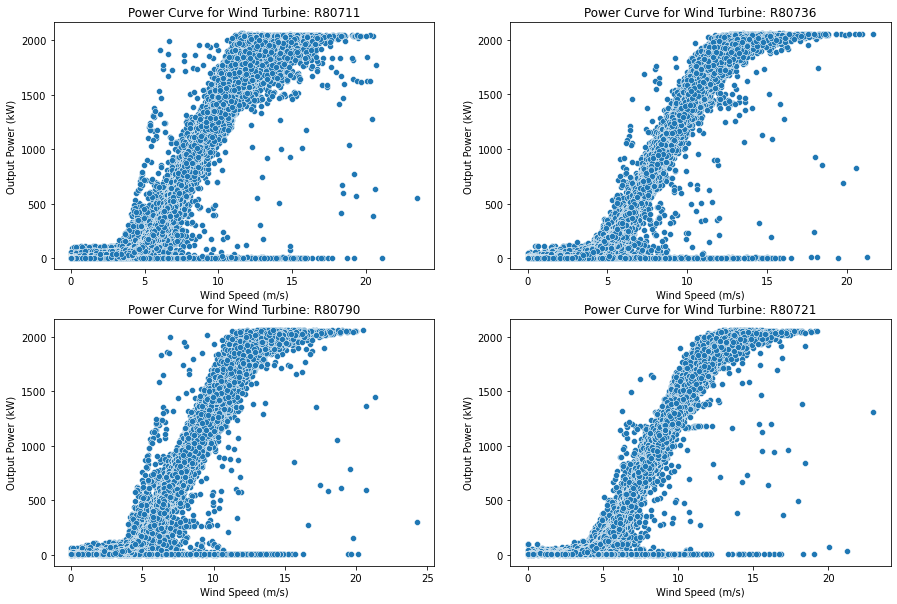

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data = df1, x='Ws', y='S')
plt.title('Power Curve for Wind Turbine: R80711')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Output Power (kW)')

plt.subplot(2,2,2)
sns.scatterplot(data = df2, x='Ws', y='S')
plt.title('Power Curve for Wind Turbine: R80736')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Output Power (kW)')

plt.subplot(2,2,3)
sns.scatterplot(data = df3, x='Ws', y='S')
plt.title('Power Curve for Wind Turbine: R80790')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Output Power (kW)')

plt.subplot(2,2,4)
sns.scatterplot(data = df4, x='Ws', y='S')
plt.title('Power Curve for Wind Turbine: R80721')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Output Power (kW)')
plt.show()

Visualizing possible outliers by ploting a boxplot.

Power production from a wind turbine is a function of wind speed. The relationship between wind speed
and power is defined by a power curve, which is unique to each turbine model and, in some cases, unique
to site-specific settings. 

The cut-in speed, at the lower end of the curve, is the threshold that the hub-height wind speed must reach for the
turbine to begin generating electricity. In general, wind turbines begin to produce power at wind speeds of about
6.7 mph (3 m/s). A turbine will achieve its nominal, or rated, power at approximately 26 mph to 30 mph (12 m/s to
13 m/s); this value is often used to describe the turbine’s generating capacity (or nameplate capacity). The turbine
will reach its cut-out speed at approximately 55 mph (25 m/s). When wind speeds exceed this, the turbine will
stop power production to protect itself from potentially damaging speeds. Variability in the wind resource results
in the turbine operating at changing power levels. At good wind energy sites, this variability results in the turbine
operating at approximately 35% to 40% of its total possible capacity over a year.
https://www.nyserda.ny.gov/-/media/Files/Publications/Research/Biomass-Solar-Wind/NY-Wind-Energy-Guide-1.pdf

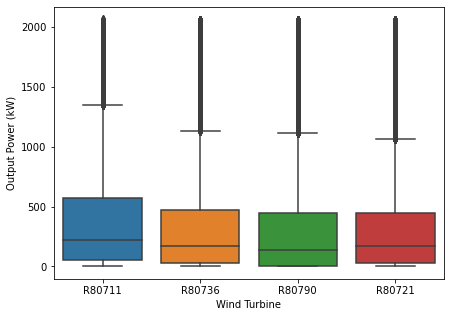

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(x = 'Wind_turbine_name', y = 'S', data = df)
plt.xlabel('Wind Turbine')
plt.ylabel('Output Power (kW)')
plt.show()

Visualizing the wind speed distribution indicated the wind speed exceeded 22m/s

This turbine has a manufacturer specification of a Cut-in wind speed: 3.5 m/s
                                                  Rated wind speed: 15 m/s
                                                  Cut-off wind speed: 22 m/s
                                                  Rated power : 2050kW

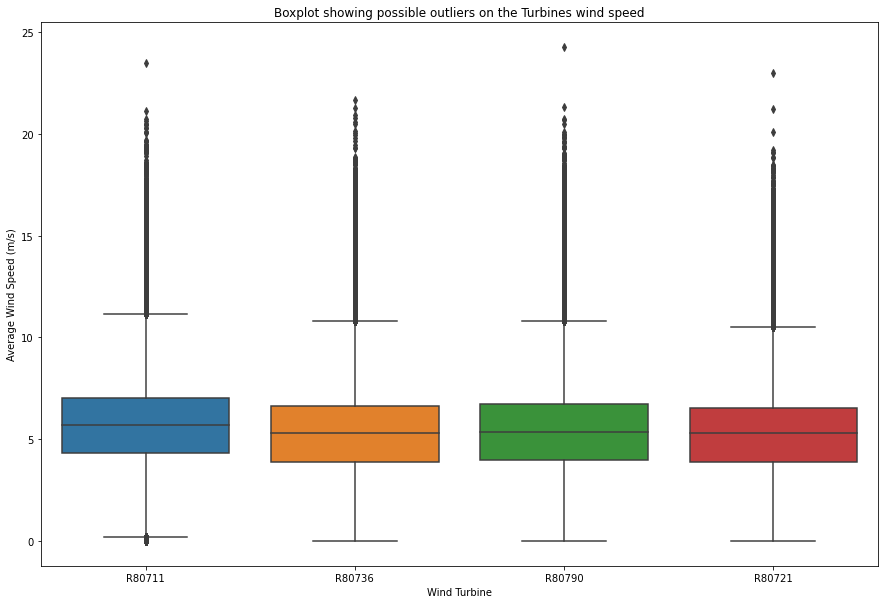

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(x = 'Wind_turbine_name', y = 'Ws', data = df)
plt.xlabel('Wind Turbine')
plt.ylabel('Average Wind Speed (m/s)')
plt.title('Boxplot showing possible outliers on the Turbines wind speed')
plt.show()

In [ ]:
# Here is the maximum wind speed
df['Ws'].max()

24.27

In [ ]:
# We have 3 scenarios where the wind speed is > 22m/s
high_Ws = df[df['Ws']>22]
high_Ws['Ws'].count()

3

In [ ]:
# Here is the maximum output power
df['S'].max()

2064.26

In [ ]:
#We have 505 scenarios where the Output power is greater that 2050kW
high_S = df[df['S']>2050]
high_S['S'].count()

505

In [ ]:
#There are 213,387 scenarios where the wind speed was below 3.5m/s
low_Ws = df[df['Ws']<3.5]
low_Ws['Ws'].count()

213387

In [ ]:
#There are 261,903 scenarios where the output power is less than 25kW
low_S = df[df['S']<25]
low_S['S'].count()

261903

In [ ]:
#Where output power is less than 25kW and wind speed is less 3.5m/s
low_Ws_S = df.loc[(df['Ws']<3.5) & (df['S']<25)]
low_Ws_S.shape

(206664, 30)

From the above, I have 2 option at handling the outliers, either by wind speed or the output power or both.
Knowing that at the cut-in wind speed the output power should 25kW and wind speed is a principal influence on the output power, it is exciting to see that other factors also influence the output power. 

Hence, I will be removing outliers by removing attributtes where the output power is less than 25kW and wind power is less than 3.5m/s. 

In [ ]:
df2=df.loc[(df['S']>=25) & (df['Ws']>=3.5)]
df2.reset_index(drop=True, inplace=True)

Visualizing the power curve after removing outliers

In [ ]:
df_copy = df2.loc[(df2['Wind_turbine_name']== 'R80711')]
df_copy = df2.loc[(df2['Wind_turbine_name']== 'R80736')]
df_copy = df2.loc[(df2['Wind_turbine_name']== 'R80790')]
df_copy = df2.loc[(df2['Wind_turbine_name']== 'R80721')]

df2['Wind_turbine_name'].value_counts()

R80711    207624
R80736    197496
R80721    197087
R80790    175504
Name: Wind_turbine_name, dtype: int64

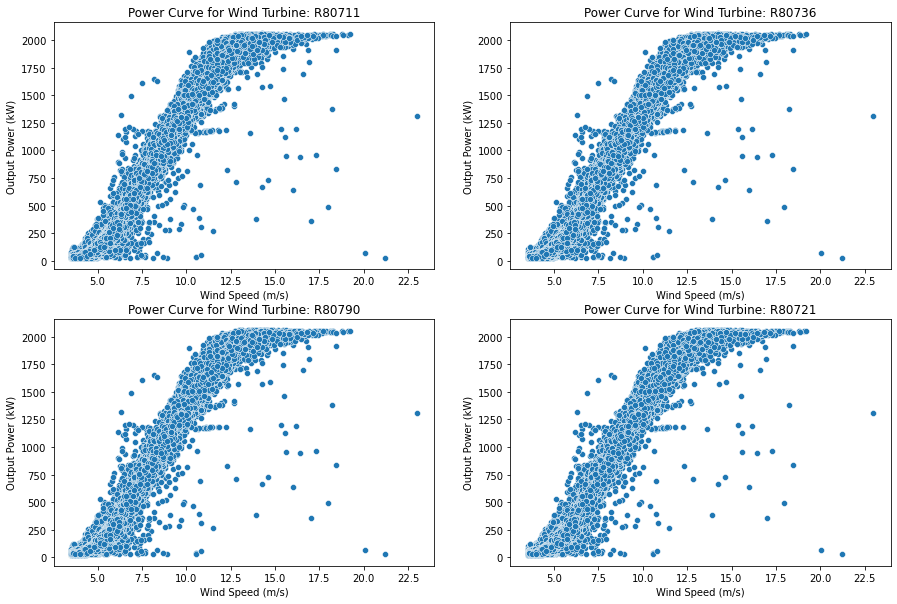

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data = df_copy, x='Ws', y='S')
plt.title('Power Curve for Wind Turbine: R80711')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Output Power (kW)')

plt.subplot(2,2,2)
sns.scatterplot(data = df_copy, x='Ws', y='S')
plt.title('Power Curve for Wind Turbine: R80736')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Output Power (kW)')

plt.subplot(2,2,3)
sns.scatterplot(data = df_copy, x='Ws', y='S')
plt.title('Power Curve for Wind Turbine: R80790')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Output Power (kW)')

plt.subplot(2,2,4)
sns.scatterplot(data = df_copy, x='Ws', y='S')
plt.title('Power Curve for Wind Turbine: R80721')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Output Power (kW)')
plt.show()

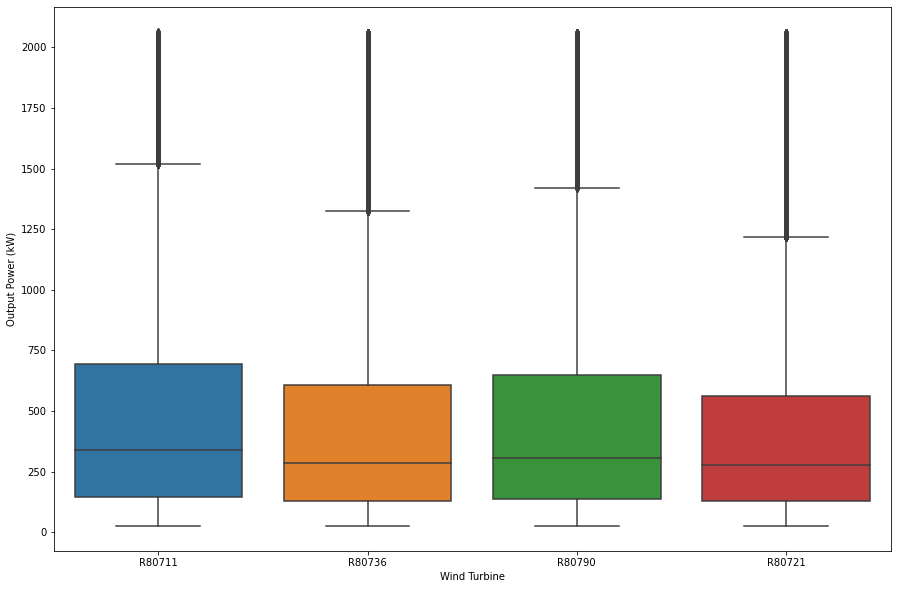

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(x = 'Wind_turbine_name', y = 'S', data = df2)
plt.xlabel('Wind Turbine')
plt.ylabel('Output Power (kW)')
plt.show()

Theoretically, the output power of a wind turbine is calculated using the formula:
 P = 0.5p*A*Cp*V^3

P: Output power, Cp: power coefficient, p (rho): air density, V: wind speed, A = Swept rotor area

The wind speed into the power of 3 indicated how important wind speed is to the output power. It is the single most important features. Some previous studies predicted output power using wind speed as the only feature. This is an approach I will also be considering, but let's see the result when we perform feature selection.

Based on this formula and and domain understanding I will be dropping less associated features

In [ ]:
df2_main = df2.drop(['P','Rt','Cosphi','Db1t','Db2t','Dst','DCs','Gb1t','Gb2t','Ws1','Ws2','Gost','Yt','Nf','Nu','Rbt','Rm','Q','Cm'], axis=1)
df2_main.head()

,Wind_turbine_name,Date_time,B,S,Ds,Git,Y,Ws,W,Ot,Rs
0,R80711,2013-01-05T22:20:00+01:00,-1.00,163.410000,1155.52000,43.459999,264.92999,5.30,298.35001,4.77,11.000000
1,R80711,2013-01-06T08:30:00+01:00,-1.00,94.320000,1019.75000,45.049999,231.67999,4.73,226.59000,5.84,9.700000
2,R80711,2013-01-06T11:20:00+01:00,-0.76,124.470000,1039.77000,49.860001,278.87000,4.76,278.01001,6.57,9.900000
3,R80711,2013-01-06T09:50:00+01:00,-1.00,183.230000,1194.10000,48.160000,278.87000,5.28,270.79999,6.20,11.370000
4,R80711,2013-01-06T07:30:00+01:00,-0.39,38.450001,970.03003,43.680000,208.98000,4.29,248.42000,5.62,9.229999


# Sorting the data

Wind turbine are greatly influenced by time and season. Hence I will be sorting the data by the date then do a manual split into training and testing set using the index number.

In [ ]:
# Sort the dataset by date 
df_sorted = df2_main.sort_values(by=['Date_time'])
df_sorted.reset_index(drop=True, inplace=True)
df_sorted

,Wind_turbine_name,Date_time,B,S,Ds,Git,Y,Ws,W,Ot,Rs
0,R80721,2013-01-01T00:00:00+01:00,-1.01,684.15997,1714.71,44.700001,165.10001,7.25,163.16000,5.72,16.360001
1,R80736,2013-01-01T00:00:00+01:00,-1.00,804.21997,1776.53,49.480000,286.00000,7.64,286.19000,5.44,16.950001
2,R80790,2013-01-01T00:00:00+01:00,-0.98,1093.81990,1800.01,48.369999,175.59000,8.56,175.05000,5.48,17.180000
3,R80711,2013-01-01T00:00:00+01:00,-1.00,1072.79000,1799.91,48.369999,161.44000,8.96,165.25000,5.09,17.180000
4,R80711,2013-01-01T00:10:00+01:00,-1.00,1061.75000,1798.88,55.080002,161.44000,8.89,168.28999,5.26,17.170000
...,...,...,...,...,...,...,...,...,...,...,...
777706,R80736,2018-01-12T23:20:00+01:00,-0.64,54.67000,973.69,49.880000,49.63000,4.27,40.63000,3.76,9.270000
777707,R80711,2018-01-12T23:20:00+01:00,-0.83,70.40000,996.08,55.480000,55.98000,4.26,61.01000,3.82,9.480000
777708,R80790,2018-01-12T23:30:00+01:00,-0.07,28.18000,970.00,52.020000,68.05000,3.69,58.53000,3.52,9.230000
777709,R80711,2018-01-12T23:30:00+01:00,-0.15,27.88000,969.98,55.250000,55.98000,3.58,56.38000,3.62,9.230000


In [ ]:
# Renaming the columns
df_sorted = df_sorted.rename(columns ={'Wind_turbine_name':'turbines',
                                                    'B':'pitch_angle',
                                                     'S':'output_power',
                                                     'Ds':'generator_speed',
                                                    'Git':'gearbox_inlet_temp',
                                                    'Ws':'wind_speed',
                                                    'Ot':'temperature',
                                                    'Rs':'rotor_speed',
                                                    'W':'wind_direction',
                                                    'Y':'nacelle_angle'})
df_sorted.head()  

,turbines,Date_time,pitch_angle,output_power,generator_speed,gearbox_inlet_temp,nacelle_angle,wind_speed,wind_direction,temperature,rotor_speed
0,R80721,2013-01-01T00:00:00+01:00,-1.01,684.15997,1714.71,44.700001,165.10001,7.25,163.16000,5.72,16.360001
1,R80736,2013-01-01T00:00:00+01:00,-1.00,804.21997,1776.53,49.480000,286.00000,7.64,286.19000,5.44,16.950001
2,R80790,2013-01-01T00:00:00+01:00,-0.98,1093.81990,1800.01,48.369999,175.59000,8.56,175.05000,5.48,17.180000
3,R80711,2013-01-01T00:00:00+01:00,-1.00,1072.79000,1799.91,48.369999,161.44000,8.96,165.25000,5.09,17.180000
4,R80711,2013-01-01T00:10:00+01:00,-1.00,1061.75000,1798.88,55.080002,161.44000,8.89,168.28999,5.26,17.170000


# Splitting the data manually

In [ ]:
df_train = df_sorted.loc[0:544398,]
#df_val = df_copy_x_sorted.loc[369148:492197,]
df_test = df_sorted.loc[544398:,]

In [ ]:
df_train.shape

(544399, 11)

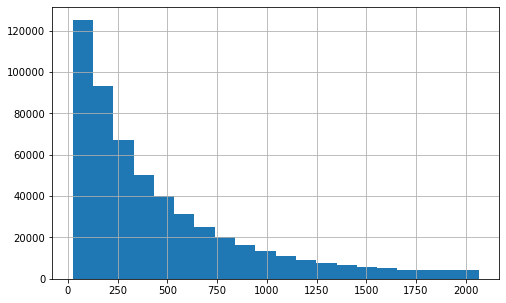

In [ ]:
# Visualizing the distribution of the output power in both the trainig and testing set after splitting the data manually.
# Feature selection model will be performed on the trainning set alone.

plt.figure(figsize=(8, 5))
df_train['output_power'].hist(bins= 20)

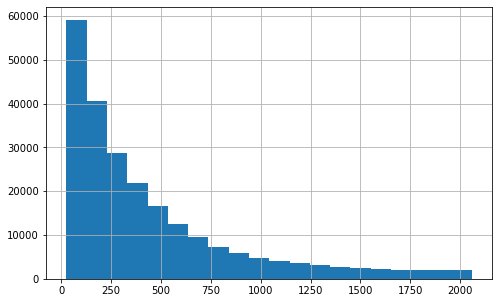

In [ ]:
plt.figure(figsize=(8, 5))
df_test['output_power'].hist(bins= 20)

# Feature Selection

Correlation Coefficient

In [ ]:
df_train.corr()

,pitch_angle,output_power,generator_speed,gearbox_inlet_temp,nacelle_angle,wind_speed,wind_direction,temperature,rotor_speed
pitch_angle,1.000000,0.068094,-0.192913,-0.127487,0.016961,0.090994,0.019436,0.040295,-0.192272
output_power,0.068094,1.000000,0.846706,-0.299723,0.043418,0.978321,0.044052,-0.183188,0.847013
generator_speed,-0.192913,0.846706,1.000000,-0.162085,0.035482,0.853478,0.034458,-0.166263,0.999999
gearbox_inlet_temp,-0.127487,-0.299723,-0.162085,1.000000,0.030690,-0.256444,0.030403,0.185290,-0.162418
nacelle_angle,0.016961,0.043418,0.035482,0.030690,1.000000,0.056545,0.893716,0.012869,0.035498
wind_speed,0.090994,0.978321,0.853478,-0.256444,0.056545,1.000000,0.056593,-0.133043,0.853695
wind_direction,0.019436,0.044052,0.034458,0.030403,0.893716,0.056593,1.000000,0.017473,0.034476
temperature,0.040295,-0.183188,-0.166263,0.185290,0.012869,-0.133043,0.017473,1.000000,-0.166257
rotor_speed,-0.192272,0.847013,0.999999,-0.162418,0.035498,0.853695,0.034476,-0.166257,1.000000


In [ ]:
df4 = df_sorted[['pitch_angle', 'generator_speed', 'wind_speed', 'temperature', 'rotor_speed', 'output_power']]

In [ ]:
df4.describe()

,pitch_angle,generator_speed,wind_speed,temperature,rotor_speed,output_power
count,777711.000000,777711.000000,777711.000000,777711.000000,777711.000000,777711.000000
mean,-0.448166,1383.025853,6.372756,11.623515,13.183097,459.027124
std,3.131836,301.517791,1.952478,7.325768,2.887873,444.258989
min,-1.530000,70.800000,3.500000,-7.970000,0.670000,25.000000
25%,-1.000000,1108.920000,5.020000,6.010000,10.560000,133.399990
50%,-0.990000,1372.000000,5.950000,11.080000,13.070000,301.190000
75%,-0.920000,1683.120000,7.150000,16.670000,16.059999,628.565005
max,88.320000,1804.569900,24.270000,38.279999,17.220000,2064.260000


In [ ]:
abs(df_train.corr()['output_power'])

pitch_angle           0.068094
output_power          1.000000
generator_speed       0.846706
gearbox_inlet_temp    0.299723
nacelle_angle         0.043418
wind_speed            0.978321
wind_direction        0.044052
temperature           0.183188
rotor_speed           0.847013
Name: output_power, dtype: float64

The correlation heatmap shows that windspeed, generator speed and rotor speed are the most correlated features to the output temperature and high correlation amoung them, also they are positively correlated, the output power tend to increase with the 3. Whereas gearbox inlet temp and temperture are negatively correlated, so the output power will decrease with and increase in any of the 2

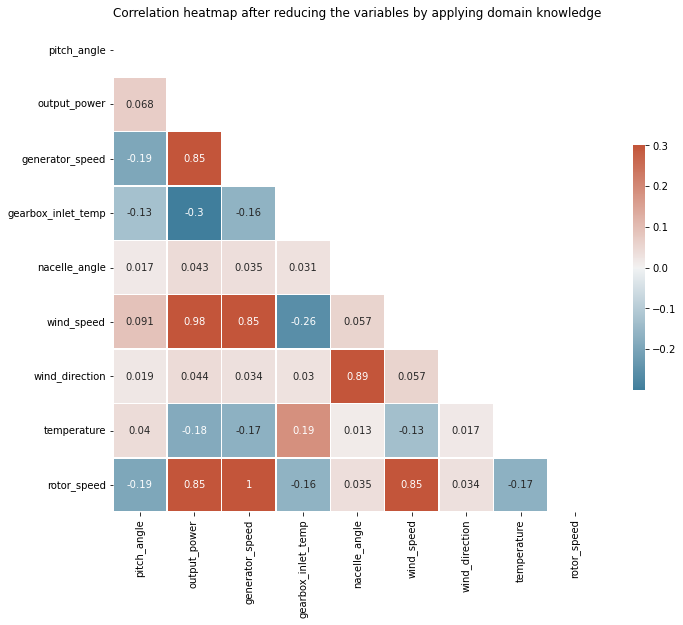

In [ ]:
#Correlation map

corr = df_train.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.title('Correlation heatmap after reducing the variables by applying domain knowledge')
plt.show()

In [ ]:
#Dropping the umwanted features from the training set.
#Splitting the training set into predictors and response

df_x = df_train.drop(['turbines','Date_time','output_power'], axis=1)
df_y = df_train.iloc[:,3]
df_y = pd.DataFrame(df_y)

df_xtest = df_test.drop(['turbines','Date_time','output_power'], axis=1)
df_ytest = df_test.iloc[:,3]
df_ytest = pd.DataFrame(df_ytest)

In [ ]:
df_x

,pitch_angle,generator_speed,gearbox_inlet_temp,nacelle_angle,wind_speed,wind_direction,temperature,rotor_speed
0,-1.01,1714.71,44.700001,165.10001,7.25,163.16000,5.720000,16.360001
1,-1.00,1776.53,49.480000,286.00000,7.64,286.19000,5.440000,16.950001
2,-0.98,1800.01,48.369999,175.59000,8.56,175.05000,5.480000,17.180000
3,-1.00,1799.91,48.369999,161.44000,8.96,165.25000,5.090000,17.180000
4,-1.00,1798.88,55.080002,161.44000,8.89,168.28999,5.260000,17.170000
...,...,...,...,...,...,...,...,...
544394,-0.99,1635.42,54.040001,240.61000,6.86,238.70000,21.370001,15.600000
544395,-0.99,1788.65,57.580002,251.34000,7.27,248.75000,20.610001,17.070000
544396,-0.99,1652.13,49.790001,250.07001,7.15,242.55000,21.190001,15.760000
544397,-0.99,1728.47,55.070000,251.34000,6.75,251.25000,21.270000,16.500000


In [ ]:
df_ytest.reset_index(drop=True, inplace=True)

I use a KFold cross validation to train different feature combinations using the absolute correlation coefficient score to eliminate the least correlated feature  with the responce feature. I print out the RMSE and R-Squared value to determine the features with the best score. 

In [ ]:
cv = KFold(n_splits=10, shuffle=False)
classifier_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10))

In [ ]:
#Ranking the features with correlation and passing it through a classifier to see if features having high correlation 
# with the response variable makes a better model.

values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for value in values:
  features = abs(df_train.corr()['output_power'][abs(df_train.corr()['output_power']) > value].drop('output_power')).index.tolist()

  x = df_train.drop(columns='output_power')
  x = x[features]

  print(features)

  df_y_pred = cross_val_predict(classifier_pipeline, x, df_y, cv=cv)
  print('RMSE: ' + str(round(sqrt(mean_squared_error(df_y, df_y_pred)), 2)))
  print('R_squared: ' + str(round(r2_score(df_y, df_y_pred), 2)))

['pitch_angle', 'generator_speed', 'gearbox_inlet_temp', 'nacelle_angle', 'wind_speed', 'wind_direction', 'temperature', 'rotor_speed']
RMSE: 38.4
R_squared: 0.99
['generator_speed', 'gearbox_inlet_temp', 'wind_speed', 'temperature', 'rotor_speed']
RMSE: 36.83
R_squared: 0.99
['generator_speed', 'gearbox_inlet_temp', 'wind_speed', 'rotor_speed']
RMSE: 39.17
R_squared: 0.99
['generator_speed', 'wind_speed', 'rotor_speed']
RMSE: 38.75
R_squared: 0.99
['generator_speed', 'wind_speed', 'rotor_speed']
RMSE: 38.75
R_squared: 0.99
['generator_speed', 'wind_speed', 'rotor_speed']
RMSE: 38.75
R_squared: 0.99
['generator_speed', 'wind_speed', 'rotor_speed']
RMSE: 38.75
R_squared: 0.99
['generator_speed', 'wind_speed', 'rotor_speed']
RMSE: 38.75
R_squared: 0.99
['generator_speed', 'wind_speed', 'rotor_speed']
RMSE: 38.75
R_squared: 0.99
['wind_speed']
RMSE: 62.02
R_squared: 0.98


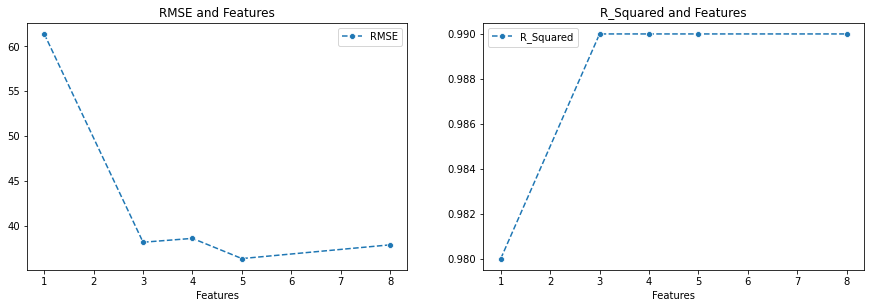

In [ ]:
Features= (8, 5, 4, 3, 1)
RMSE= (37.85, 36.32, 38.57, 38.14, 61.35)
R_Squared = (0.99,0.99,0.99,0.99,0.98)

plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.lineplot(x = Features, y = RMSE, linestyle='--', marker='o', label = 'RMSE')
plt.legend()
plt.title('RMSE and Features')
plt.xlabel('Features')

plt.subplot(2,2,2)
sns.lineplot(x = Features, y = R_Squared, linestyle='--', marker='o', label = 'R_Squared')
plt.legend()
plt.title('R_Squared and Features')
plt.xlabel('Features')
plt.show()

# Using Forward and Backward Subset Selection

In [ ]:
#applying forward subset selection to identify the important features

sfs1 = SFS(classifier_pipeline, k_features=8, forward=True, scoring='neg_mean_squared_error', cv=cv)

sfs1.fit(df_x, df_y)
sfs1.subsets_

{1: {'feature_idx': (4,),
  'cv_scores': array([-3091.10156525, -3060.26552924, -2920.46108227, -2707.86830905,
         -2070.30774978, -6841.39542071, -4055.40968454, -3467.58106088,
         -6000.4660691 , -3419.71849041]),
  'avg_score': -3763.4574961239114,
  'feature_names': ('wind_speed',)},
 2: {'feature_idx': (1, 4),
  'cv_scores': array([-1270.51638767, -1186.3183509 , -1291.86536571,  -947.82204771,
          -637.09315029, -2940.97400164, -1212.81755873, -1420.76509986,
         -2617.07982801, -1033.73685746]),
  'avg_score': -1455.898864797639,
  'feature_names': ('generator_speed', 'wind_speed')},
 3: {'feature_idx': (1, 4, 6),
  'cv_scores': array([ -907.54495299,  -685.49392137, -1162.82715036,  -721.17976893,
          -406.21183586, -2639.11735283,  -968.5311643 , -1359.47268736,
         -2672.83202217,  -963.78514837]),
  'avg_score': -1248.6996004535217,
  'feature_names': ('generator_speed', 'wind_speed', 'temperature')},
 4: {'feature_idx': (0, 1, 4, 6),
  'cv_

In [ ]:
#Applying backward selection to compare with result from forward selection

sfs1 = SFS(classifier_pipeline, k_features=1, forward=False, scoring='neg_mean_squared_error', cv=cv)

sfs1.fit(df_x, df_y)
sfs1.subsets_

{8: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7),
  'cv_scores': array([-1380.29969191,  -819.77306435, -1298.80868247,  -876.2296384 ,
          -498.14350584, -2923.94053175, -1110.88088297, -1454.89946868,
         -3047.33818818,  -915.10626032]),
  'avg_score': -1432.5419914854133,
  'feature_names': ('pitch_angle',
   'generator_speed',
   'gearbox_inlet_temp',
   'nacelle_angle',
   'wind_speed',
   'wind_direction',
   'temperature',
   'rotor_speed')},
 7: {'feature_idx': (0, 1, 3, 4, 5, 6, 7),
  'cv_scores': array([-1309.15240128,  -784.93320105, -1295.49879966,  -838.36960628,
          -450.005186  , -2676.73256184, -1009.54560043, -1243.66944736,
         -2969.91463798,  -834.5019234 ]),
  'avg_score': -1341.2323365292975,
  'feature_names': ('pitch_angle',
   'generator_speed',
   'nacelle_angle',
   'wind_speed',
   'wind_direction',
   'temperature',
   'rotor_speed')},
 6: {'feature_idx': (0, 1, 4, 5, 6, 7),
  'cv_scores': array([-1136.24359857,  -729.44502922, -1160.7436

From the subset selection model Wind Speed, Pitch Angle, Temperature, Generator Speed, and Rotor Speed has the best avgrage score with the training data.
My final dataset will have wind speed, generator speed, temperature, rotor speed and pitch angle

In [ ]:
x_train = df_x[['pitch_angle','generator_speed','wind_speed','temperature', 'rotor_speed']].copy()
x_test = df_xtest[['pitch_angle','generator_speed','wind_speed','temperature', 'rotor_speed']].copy()

# Scaling the data: feature scaling

Normalization or Min-Max Scaling is used to transform features to be on a similar scale. The scale is of range [0,1]. 
It is useful when there are no outliers as it cannot cope with them.
X_new = (X - X_min)/(X_max - X_min)

Standardization or Z-Score Normalization rescales data to have a mean of [0] and a standard deviation of [1] (unit variance). It can be helpful in cases where the data follows a Gaussian distribution. 
It does not get affected by outliers because there is no predefined range.
X_new = (X - mean)/Std

For this dataset I will be using the Standard scaler normalization because it is more robust to outliers.

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled

array([[-0.17905913,  1.08241911,  0.4406105 , -0.77962602,  1.08245182],
       [-0.17579278,  1.2875271 ,  0.64227585, -0.81864199,  1.28683112],
       [-0.16926008,  1.36542965,  1.11799964, -0.81306829,  1.36650406],
       ...,
       [-0.17252643,  0.87478958,  0.38890147,  1.37600901,  0.87460811],
       [-0.17252643,  1.1280724 ,  0.1820651 ,  1.38715631,  1.13094826],
       [-0.17252643,  1.33958379,  0.62159222,  1.28543612,  1.33879161]])

In [ ]:
x_test_scaled = scaler.fit_transform(x_test)
x_test_scaled

array([[-0.17437413,  1.39973263,  0.64491953,  1.07648972,  1.39895756],
       [-0.17437413,  1.25647053,  0.38412691,  1.15134976,  1.25692956],
       [-0.17437413,  0.86815659,  0.34902036,  1.16316977,  0.86894934],
       ...,
       [ 0.1052753 , -1.32821925, -1.31604036, -1.15880497, -1.32729385],
       [ 0.08095796, -1.3282856 , -1.37120803, -1.14567163, -1.32729385],
       [ 0.10831497, -1.32785429, -1.40129949, -1.28225838, -1.32729385]])

In [ ]:
features = list(x_train.columns)
features

['pitch_angle', 'generator_speed', 'wind_speed', 'temperature', 'rotor_speed']

In [ ]:
y_train = df_y
y_test = df_ytest

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_model = lin_reg.fit(x_train_scaled, y_train)

The training error is 

In [ ]:
# On the training set
predict_train = lin_model.predict(x_train_scaled)
lin_mse = mean_squared_error(y_train, predict_train)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

80.32773473767851

In [ ]:
r2= r2_score(y_train, predict_train)
r2

0.9670987994498405

In [ ]:
predict_train

array([[683.23626332],
       [750.44927878],
       [997.72836475],
       ...,
       [603.52947389],
       [603.66839306],
       [691.09501116]])

In [ ]:
lin_model.coef_

array([[-2.21861356e+01, -2.73688520e+04,  4.16627268e+02,
        -2.31067990e+01,  2.73801444e+04]])

Predicting the test set

In [ ]:
original_values = y_test

predicted_values = lin_reg.predict(x_test_scaled)

In [ ]:
lin_mse = mean_squared_error(original_values, predicted_values)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

91.4835302211981

In [ ]:
r2= r2_score(original_values, predicted_values)
r2

0.9581615273949384

In [ ]:
predicted_values = pd.DataFrame(predicted_values, columns=['predicted_power'])

<Figure size 720x576 with 0 Axes>

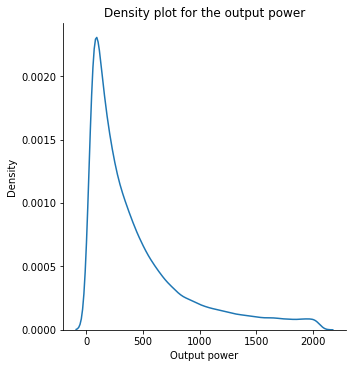

In [ ]:
plt.figure(figsize=(10, 8))
sns.displot(original_values, x='output_power', kind='kde')
plt.title('Density plot for the output power')
plt.xlabel('Output power')
plt.ylabel('Density')
plt.show()

<Figure size 720x576 with 0 Axes>

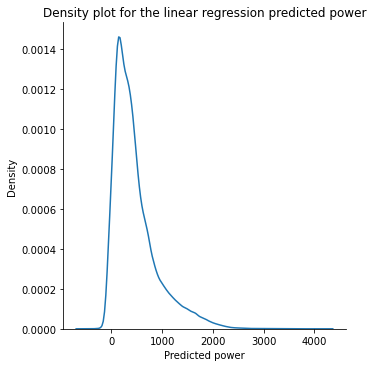

In [ ]:
plt.figure(figsize=(10, 8))
sns.displot(predicted_values, x='predicted_power', kind='kde')
plt.title('Density plot for the linear regression predicted power')
plt.xlabel('Predicted power')
plt.ylabel('Density')
plt.show()

# Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=0.001, penalty=None, eta0=0.1)
sgd_reg.fit(x_train_scaled, y_train)

C:\Users\tolua\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SGDRegressor(eta0=0.1, penalty=None)

In [ ]:
sgd_predict = sgd_reg.predict(x_test_scaled)

In [ ]:
sgd_mse = mean_squared_error(original_values, sgd_predict)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

99.76111850783583

In [ ]:
r2= r2_score(original_values, sgd_predict)
r2

0.950247763216195

# Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x_train_scaled)

In [ ]:
x_test_poly = poly_features.fit_transform(x_test_scaled)

In [ ]:
x_train_scaled[0]

array([-0.17905913,  1.08241911,  0.4406105 , -0.77962602,  1.08245182])

In [ ]:
x_poly[0]

array([-0.17905913,  1.08241911,  0.4406105 , -0.77962602,  1.08245182,
        0.03206217, -0.19381702, -0.07889533,  0.13959916, -0.19382288,
        1.17163114,  0.47692522, -0.84388211,  1.17166654,  0.19413761,
       -0.34351141,  0.47693964,  0.60781673, -0.8439076 ,  1.17170194])

In [ ]:
poly_reg = LinearRegression()
poly_reg.fit(x_poly, y_train)

LinearRegression()

In [ ]:
poly_predicted = poly_reg.predict(x_test_poly)

In [ ]:
poly_mse = mean_squared_error(original_values, poly_predicted)
poly_rmse = np.sqrt(poly_mse)
poly_rmse

58.303616094994375

In [ ]:
r2= r2_score(original_values, poly_predicted)
r2

0.9830065728572165

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_model=tree_reg.fit(x_train_scaled, y_train)

In [ ]:
train_predictions = tree_reg.predict(x_test_scaled)
tree_mse = mean_squared_error(original_values, train_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

79.26537024922501

In [ ]:
r2= r2_score(original_values, train_predictions)
r2

0.9685907926666062

In [ ]:
from sklearn import tree

text_representation = tree.export_text(tree_reg)
print(text_representation)

|--- feature_2 <= 0.59
|   |--- feature_1 <= 0.06
|   |   |--- feature_1 <= -0.72
|   |   |   |--- value: [94.24]
|   |   |--- feature_1 >  -0.72
|   |   |   |--- value: [242.06]
|   |--- feature_1 >  0.06
|   |   |--- feature_1 <= 0.72
|   |   |   |--- value: [420.20]
|   |   |--- feature_1 >  0.72
|   |   |   |--- value: [628.95]
|--- feature_2 >  0.59
|   |--- feature_2 <= 1.72
|   |   |--- feature_2 <= 1.09
|   |   |   |--- value: [855.16]
|   |   |--- feature_2 >  1.09
|   |   |   |--- value: [1141.17]
|   |--- feature_2 >  1.72
|   |   |--- feature_2 <= 2.46
|   |   |   |--- value: [1463.88]
|   |   |--- feature_2 >  2.46
|   |   |   |--- value: [1834.40]



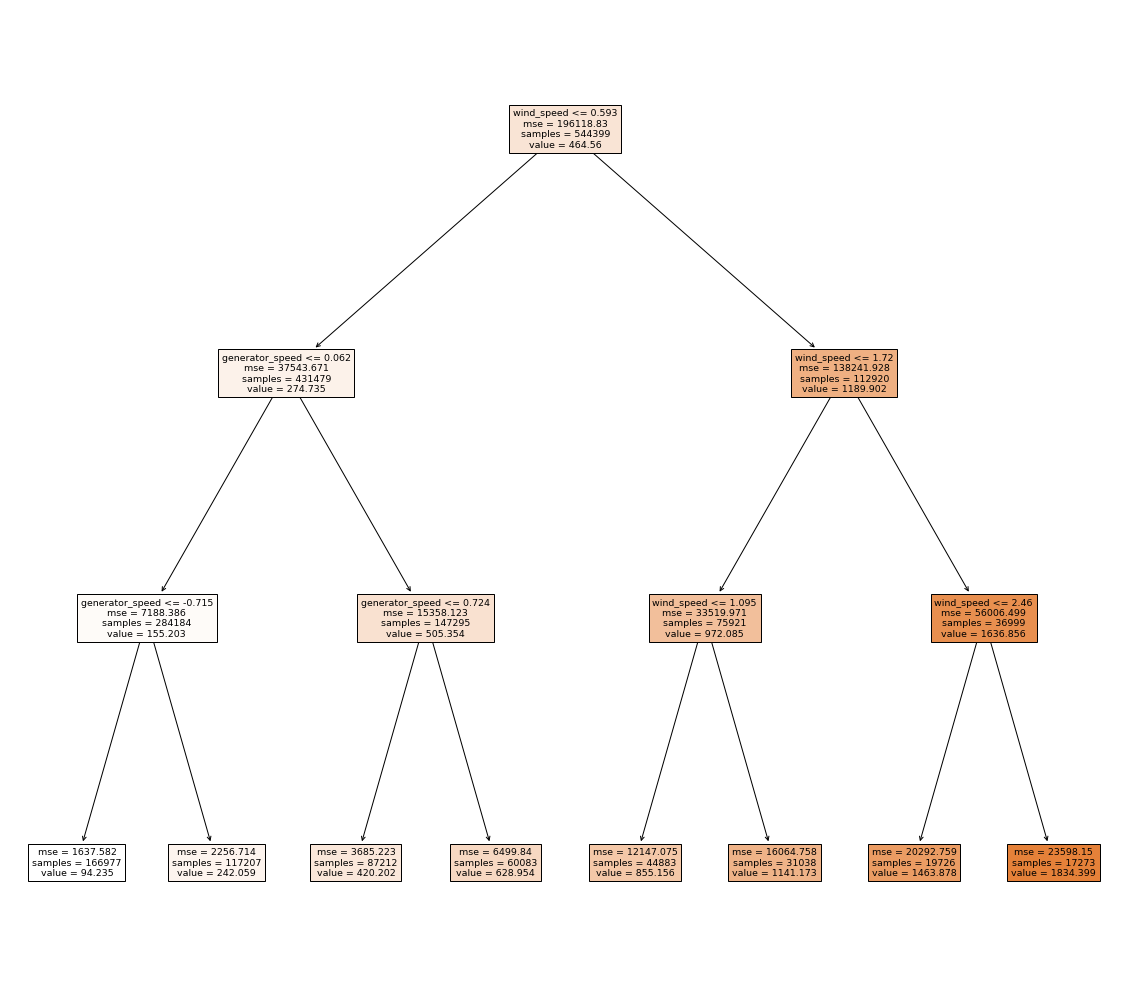

In [ ]:
fig = plt.figure(figsize=(20,18))
tree.plot_tree(tree_reg, feature_names=features, filled=True)
plt.show()

In [ ]:
df_train.columns[2:]

Index(['pitch_angle', 'output_power', 'generator_speed', 'gearbox_inlet_temp',
       'nacelle_angle', 'wind_speed', 'wind_direction', 'temperature',
       'rotor_speed'],
      dtype='object')

# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(x_train_scaled, y_train)

<ipython-input-106-037bba05bdbe>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(x_train_scaled, y_train)


RandomForestRegressor(n_estimators=10, random_state=42)

In [ ]:
train_predictions = forest_reg.predict(x_test_scaled)
forest_mse = mean_squared_error(original_values, train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

47.296058206976305

In [ ]:
r2= r2_score(original_values, train_predictions)
r2

0.9848231381932627

# Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gboost = GradientBoostingRegressor(n_estimators=120, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
gboost.fit(x_train_scaled, y_train)

C:\Users\tolua\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=120,
                          random_state=5)

In [ ]:
gboost_predictions = gboost.predict(x_test_scaled)
gboost_mse = mean_squared_error(original_values, gboost_predictions)
gboost_rmse = np.sqrt(gboost_mse)
gboost_rmse

45.18997926816317

In [ ]:
r2= r2_score(original_values, gboost_predictions)
r2

0.9897912098785617

# Stacked Regressions

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
averaged_models = AveragingModels(models = (lin_reg, sgd_reg, poly_reg, tree_reg, gboost))

In [ ]:
models = (lin_reg, sgd_reg, poly_reg, tree_reg, gboost)

In [ ]:
averaged_models.fit(x_train_scaled, y_train)

C:\Users\tolua\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\tolua\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AveragingModels(models=(LinearRegression(),
                        SGDRegressor(eta0=0.1, penalty=None),
                        LinearRegression(),
                        DecisionTreeRegressor(random_state=42),
                        GradientBoostingRegressor(learning_rate=0.05,
                                                  loss='huber', max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_leaf=15,
                                                  min_samples_split=10,
                                                  n_estimators=120,
                                                  random_state=5)))

In [ ]:
stack_predictions = averaged_models.predict(x_test_scaled)
stack_mse = mean_squared_error(original_values, stack_predictions)
stack_rmse = np.sqrt(stack_mse)
stack_rmse

64.64426352260384

In [ ]:
r2= r2_score(original_values, stack_predictions)
r2

0.9791094451352341

GradientBoostingRegressor has a better result than stacking

--------------------------------------------------------------------------------------------------------

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data = df_copy, x='Ws', y='S')
plt.title('Power Curve for Wind Turbine: R80711')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Output Power (kW)')


64.64426352260384

In [ ]:
df_sorted

,turbines,Date_time,pitch_angle,output_power,generator_speed,gearbox_inlet_temp,nacelle_angle,wind_speed,wind_direction,temperature,rotor_speed
0,R80721,2013/01/01T00:00:00+01:00,-1.01,684.15997,1714.71,44.700001,165.10001,7.25,163.16000,5.72,16.360001
1,R80736,2013/01/01T00:00:00+01:00,-1.00,804.21997,1776.53,49.480000,286.00000,7.64,286.19000,5.44,16.950001
2,R80790,2013/01/01T00:00:00+01:00,-0.98,1093.81990,1800.01,48.369999,175.59000,8.56,175.05000,5.48,17.180000
3,R80711,2013/01/01T00:00:00+01:00,-1.00,1072.79000,1799.91,48.369999,161.44000,8.96,165.25000,5.09,17.180000
4,R80711,2013/01/01T00:10:00+01:00,-1.00,1061.75000,1798.88,55.080002,161.44000,8.89,168.28999,5.26,17.170000
...,...,...,...,...,...,...,...,...,...,...,...
777706,R80736,2018/01/12T23:20:00+01:00,-0.64,54.67000,973.69,49.880000,49.63000,4.27,40.63000,3.76,9.270000
777707,R80711,2018/01/12T23:20:00+01:00,-0.83,70.40000,996.08,55.480000,55.98000,4.26,61.01000,3.82,9.480000
777708,R80790,2018/01/12T23:30:00+01:00,-0.07,28.18000,970.00,52.020000,68.05000,3.69,58.53000,3.52,9.230000
777709,R80711,2018/01/12T23:30:00+01:00,-0.15,27.88000,969.98,55.250000,55.98000,3.58,56.38000,3.62,9.230000


In [ ]:
df_sorted.to_csv('out.csv')

In [ ]:
df= pd.read_csv('out.csv', index_col = 2, parse_dates=True)

In [ ]:
df.index.freq='MS'

In [ ]:
df

,Unnamed: 0,turbines,pitch_angle,output_power,generator_speed,gearbox_inlet_temp,nacelle_angle,wind_speed,wind_direction,temperature,rotor_speed
Date_time,,,,,,,,,,,
2013-01-01 00:00:00+01:00,0,R80721,-1.01,684.15997,1714.71,44.700001,165.10001,7.25,163.16000,5.72,16.360001
2013-01-01 00:00:00+01:00,1,R80736,-1.00,804.21997,1776.53,49.480000,286.00000,7.64,286.19000,5.44,16.950001
2013-01-01 00:00:00+01:00,2,R80790,-0.98,1093.81990,1800.01,48.369999,175.59000,8.56,175.05000,5.48,17.180000
2013-01-01 00:00:00+01:00,3,R80711,-1.00,1072.79000,1799.91,48.369999,161.44000,8.96,165.25000,5.09,17.180000
2013-01-01 00:10:00+01:00,4,R80711,-1.00,1061.75000,1798.88,55.080002,161.44000,8.89,168.28999,5.26,17.170000
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-12 23:20:00+01:00,777706,R80736,-0.64,54.67000,973.69,49.880000,49.63000,4.27,40.63000,3.76,9.270000
2018-01-12 23:20:00+01:00,777707,R80711,-0.83,70.40000,996.08,55.480000,55.98000,4.26,61.01000,3.82,9.480000
2018-01-12 23:30:00+01:00,777708,R80790,-0.07,28.18000,970.00,52.020000,68.05000,3.69,58.53000,3.52,9.230000


In [ ]:
df = df.drop(['Unnamed: 0','pitch_angle','generator_speed','gearbox_inlet_temp','nacelle_angle','wind_speed','wind_direction','temperature','rotor_speed'], axis=1)

In [ ]:
df

,turbines,output_power
Date_time,,
2013-01-01 00:00:00+01:00,R80721,684.15997
2013-01-01 00:00:00+01:00,R80736,804.21997
2013-01-01 00:00:00+01:00,R80790,1093.81990
2013-01-01 00:00:00+01:00,R80711,1072.79000
2013-01-01 00:10:00+01:00,R80711,1061.75000
...,...,...
2018-01-12 23:20:00+01:00,R80736,54.67000
2018-01-12 23:20:00+01:00,R80711,70.40000
2018-01-12 23:30:00+01:00,R80790,28.18000


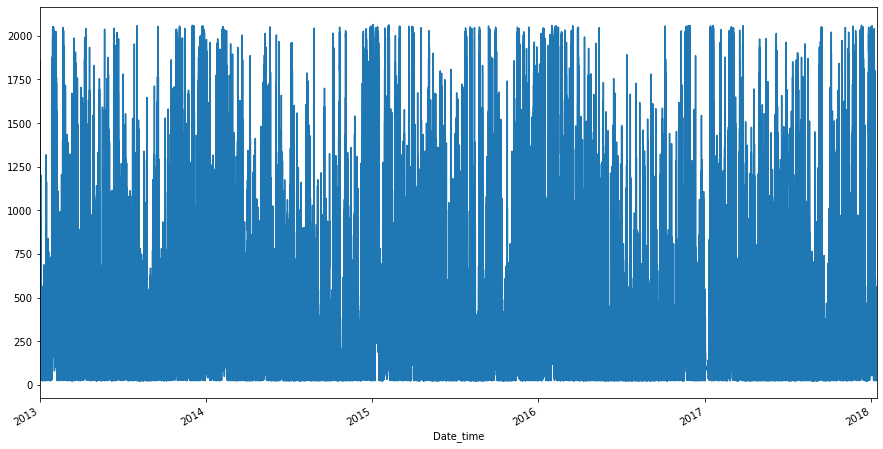

In [ ]:
df['output_power'].plot().autoscale(axis='x', tight=True)

In [ ]:
dfs1 = df.loc[(df['turbines']== 'R80711')]
dfs2 = df.loc[(df['turbines']== 'R80736')]
dfs3 = df.loc[(df['turbines']== 'R80790')]
dfs4 = df.loc[(df['turbines']== 'R80721')]

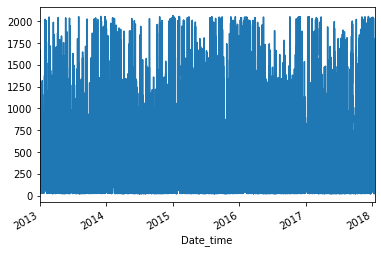

In [ ]:
dfs1['output_power'].plot().autoscale(axis='x', tight=True)

In [ ]:
dfs1

,turbines,output_power
Date_time,,
2013-01-01 00:00:00+01:00,R80711,1072.7900
2013-01-01 00:10:00+01:00,R80711,1061.7500
2013-01-01 00:20:00+01:00,R80711,1145.1400
2013-01-01 00:30:00+01:00,R80711,1184.3199
2013-01-01 00:40:00+01:00,R80711,1317.6899
...,...,...
2018-01-12 23:00:00+01:00,R80711,170.5600
2018-01-12 23:10:00+01:00,R80711,131.9200
2018-01-12 23:20:00+01:00,R80711,70.4000


In [ ]:
dfs1.head(50)

,turbines,output_power
Date_time,,
2013-01-01 00:00:00+01:00,R80711,1072.79000
2013-01-01 00:10:00+01:00,R80711,1061.75000
2013-01-01 00:20:00+01:00,R80711,1145.14000
2013-01-01 00:30:00+01:00,R80711,1184.31990
2013-01-01 00:40:00+01:00,R80711,1317.68990
2013-01-01 00:50:00+01:00,R80711,1282.20000
2013-01-01 01:00:00+01:00,R80711,1303.89000
2013-01-01 01:10:00+01:00,R80711,1276.22000
2013-01-01 01:20:00+01:00,R80711,1286.38000


In [ ]:
dfs1['daily_MA']= dfs1['output_power'].rolling(window=4380).mean()
dfs1['daily_STD']= dfs1['output_power'].rolling(window=4380).std()

In [ ]:
dfs1

,turbines,output_power,daily_MA,daily_STD
Date_time,,,,
2013-01-01 00:00:00+01:00,R80711,1072.7900,NaN,NaN
2013-01-01 00:10:00+01:00,R80711,1061.7500,NaN,NaN
2013-01-01 00:20:00+01:00,R80711,1145.1400,NaN,NaN
2013-01-01 00:30:00+01:00,R80711,1184.3199,NaN,NaN
2013-01-01 00:40:00+01:00,R80711,1317.6899,NaN,NaN
...,...,...,...,...
2018-01-12 23:00:00+01:00,R80711,170.5600,831.197432,641.275549
2018-01-12 23:10:00+01:00,R80711,131.9200,831.108667,641.345440
2018-01-12 23:20:00+01:00,R80711,70.4000,831.027340,641.419325


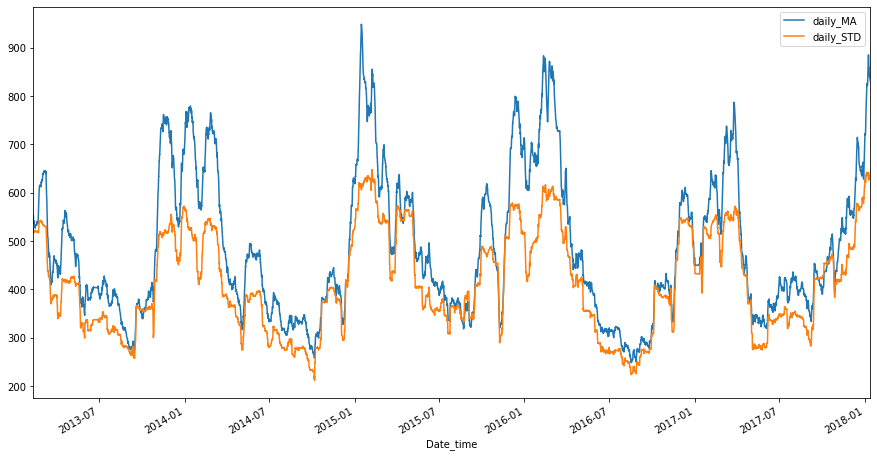

In [ ]:
dfs1[['daily_MA', 'daily_STD']].plot().autoscale(axis='x', tight=True)

ETS Decomposition

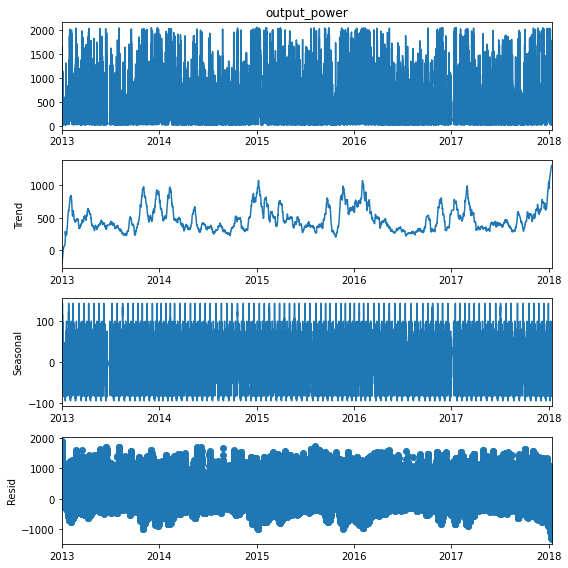

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dfs1['output_power'], model='additive', extrapolate_trend='freq', period=2190)
plt.rcParams.update({'figure.figsize': (8,8)})
result.plot();

Differencing

First Order Differencing

In [ ]:
dfs1['shift'] = dfs1['output_power'].shift(1)
dfs1.head()

,Unnamed: 0,turbines,pitch_angle,output_power,generator_speed,gearbox_inlet_temp,nacelle_angle,wind_speed,wind_direction,temperature,rotor_speed,shift
Date_time,,,,,,,,,,,,
2013-01-01 00:00:00+01:00,3,R80711,-1.00,1072.7900,1799.9100,48.369999,161.44000,8.960000,165.25000,5.09,17.18,NaN
2013-01-01 00:10:00+01:00,4,R80711,-1.00,1061.7500,1798.8800,55.080002,161.44000,8.890000,168.28999,5.26,17.17,1072.7900
2013-01-01 00:20:00+01:00,11,R80711,-1.00,1145.1400,1800.0900,56.779999,161.44000,9.190000,170.08000,5.56,17.18,1061.7500
2013-01-01 00:30:00+01:00,13,R80711,-1.00,1184.3199,1800.0601,55.529999,173.41000,8.920000,175.33000,5.70,17.18,1145.1400
2013-01-01 00:40:00+01:00,18,R80711,-0.98,1317.6899,1799.9301,47.980000,177.89999,9.479999,173.07001,5.82,17.18,1184.3199


In [ ]:
dfs1['diff'] = dfs1['output_power']-dfs1['output_power'].shift(1)
dfs1.head()

,Unnamed: 0,turbines,pitch_angle,output_power,generator_speed,gearbox_inlet_temp,nacelle_angle,wind_speed,wind_direction,temperature,rotor_speed,shift,diff
Date_time,,,,,,,,,,,,,
2013-01-01 00:00:00+01:00,3,R80711,-1.00,1072.7900,1799.9100,48.369999,161.44000,8.960000,165.25000,5.09,17.18,NaN,NaN
2013-01-01 00:10:00+01:00,4,R80711,-1.00,1061.7500,1798.8800,55.080002,161.44000,8.890000,168.28999,5.26,17.17,1072.7900,-11.0400
2013-01-01 00:20:00+01:00,11,R80711,-1.00,1145.1400,1800.0900,56.779999,161.44000,9.190000,170.08000,5.56,17.18,1061.7500,83.3900
2013-01-01 00:30:00+01:00,13,R80711,-1.00,1184.3199,1800.0601,55.529999,173.41000,8.920000,175.33000,5.70,17.18,1145.1400,39.1799
2013-01-01 00:40:00+01:00,18,R80711,-0.98,1317.6899,1799.9301,47.980000,177.89999,9.479999,173.07001,5.82,17.18,1184.3199,133.3700


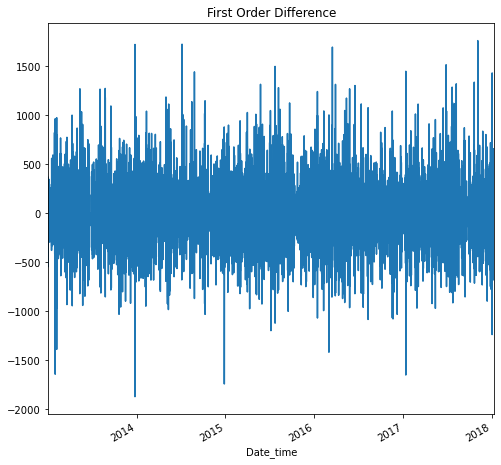

In [ ]:
dfs1['diff'].plot(title='First Order Difference').autoscale(axis='x', tight=True)

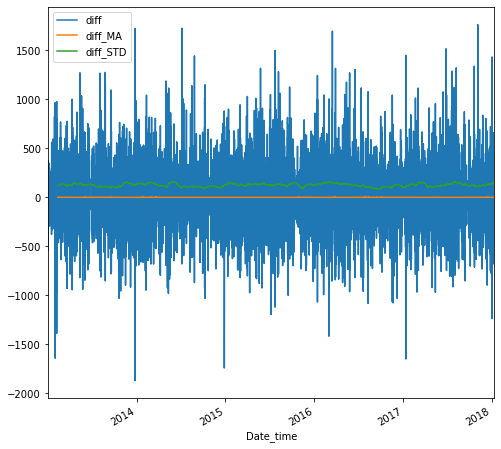

In [ ]:
dfs1['diff_MA']= dfs1['diff'].rolling(window=4380).mean()
dfs1['diff_STD']= dfs1['diff'].rolling(window=4380).std()

dfs1[['diff', 'diff_MA', 'diff_STD']].plot().autoscale(axis='x', tight=True)

Augmented Dickey Fuller Test
to determine the stationarity 

In [ ]:
from statsmodels.tsa.stattools import adfuller

print('Augmented Dickey Fuller Test')

dfs1_test = adfuller(dfs1['output_power'],autolag='AIC')
dfs1_test

Augmented Dickey Fuller Test


(-28.96881249557665,
 0.0,
 60,
 207563,
 {'1%': -3.430381505523015,
  '5%': -2.8615539250270983,
  '10%': -2.566777411790797},
 2585276.342090881)

In [ ]:
print('Augmented Dickey Fuller Test')

dfs1_out = pd.Series(dfs1_test[0:4],index=['ADF test statistics', 'p-value', '# lags used', '# observations'])

for key,val in dfs1_test[4].items():
    dfs1_out[f'critical value ({key})']=val
    
print(dfs1_out)    

Augmented Dickey Fuller Test
ADF test statistics        -28.968812
p-value                      0.000000
# lags used                 60.000000
# observations          207563.000000
critical value (1%)         -3.430382
critical value (5%)         -2.861554
critical value (10%)        -2.566777
dtype: float64


ACF Plot

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

acf(dfs1['output_power'])

C:\Users\tolua\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([1.        , 0.96241748, 0.93459775, 0.91451635, 0.89777493,
       0.88276101, 0.86885799, 0.85596794, 0.84400966, 0.83222895,
       0.8204736 , 0.80933885, 0.79837382, 0.78813316, 0.77822061,
       0.76855888, 0.75908846, 0.74976145, 0.74028254, 0.73106907,
       0.72183756, 0.71277067, 0.7038161 , 0.69488157, 0.68619092,
       0.67787968, 0.66946943, 0.66114712, 0.65294644, 0.64504093,
       0.637285  , 0.62957436, 0.62204973, 0.61479877, 0.60750979,
       0.60011886, 0.59280007, 0.58553085, 0.57832713, 0.57128371,
       0.56447513])

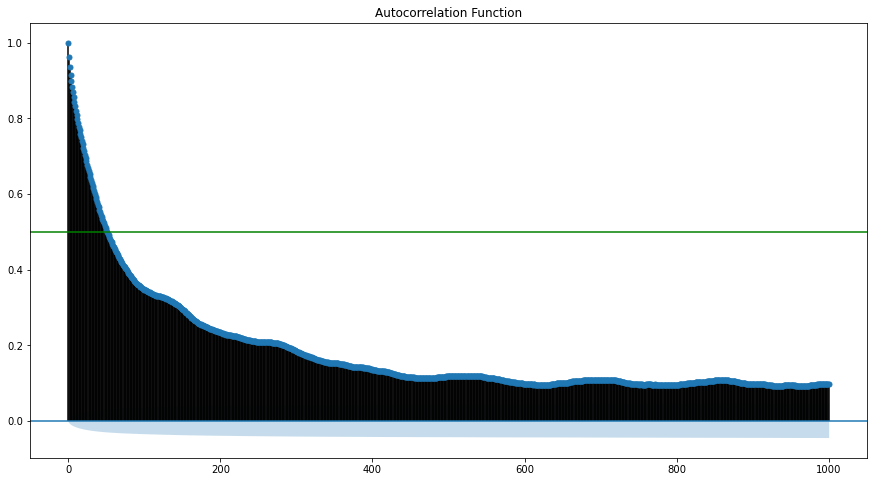

In [ ]:
title = 'Autocorrelation Function'
lags =1000
plt.rcParams.update({'figure.figsize': (15,8)})
plot_acf(dfs1['output_power'], title=title , lags=lags)
plt.axhline(y=0.5, color='green');

PACF Plot

(<Figure size 1080x504 with 1 Axes>,)

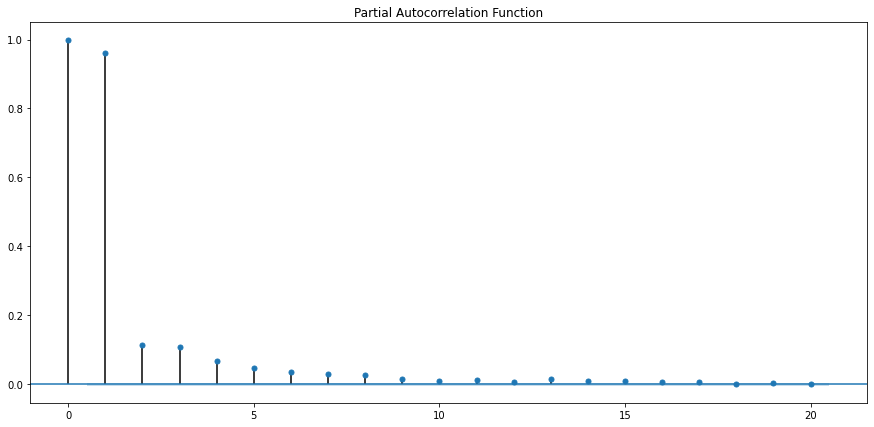

In [ ]:
title = 'Partial Autocorrelation Function'
lags = 20
plt.rcParams.update({'figure.figsize': (15,7)})
plot_pacf(dfs1['output_power'], title=title , lags=lags),

1. Visualize the time series
2. Stationaries the series
3. Plot ACF/PACF charts and find optimal parameters
4. Build the ARIMA model
5. Make predictions


In [ ]:
from pmdarima import auto_arima

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dfs1

,turbines,output_power
Date_time,,
2013-01-01 00:00:00+01:00,R80711,1072.7900
2013-01-01 00:10:00+01:00,R80711,1061.7500
2013-01-01 00:20:00+01:00,R80711,1145.1400
2013-01-01 00:30:00+01:00,R80711,1184.3199
2013-01-01 00:40:00+01:00,R80711,1317.6899
...,...,...
2018-01-12 23:00:00+01:00,R80711,170.5600
2018-01-12 23:10:00+01:00,R80711,131.9200
2018-01-12 23:20:00+01:00,R80711,70.4000


In [ ]:
dfs1 = dfs1.drop(['turbines'], axis=1)

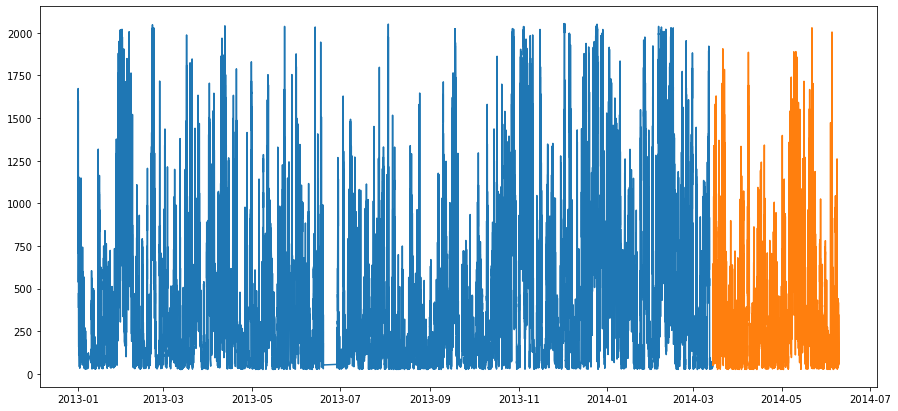

In [ ]:
train = dfs1[:50000]
test = dfs1[50000:60000]
plt.plot(train)
plt.plot(test)

In [ ]:
stepwise_fit = auto_arima(train, start_p=9, start_q=1000,
                         max_p=10, max_q=1002, m=12,
                         seasonal=True,
                         d=1, D=1,trace=True,
                         error_action='warn',
                         suppress_warnings=True,
                         stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(9,1,11)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=661300.958, Time=2.82 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=646189.046, Time=48.85 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=80.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=660314.853, Time=2.73 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=639973.161, Time=117.92 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=759.18 sec
